# 4. Model Selection

To recap, so far we have read in our data, cleaned our data, and engineered some new features. We have broken out our future training data in three ways: 

 - *Joke Text*
 - *Comment Text*
 - *Joke and Comment Text*

In this notebook, we will focus on some **additional pre-processing steps** that will aid us in model selection. We will also **iteratively build and score models** to select the best performer. We'll then test our NLP model against a more traditional Logistic Regression model using a significantly simpler set of features. Finally, we will take some time to explore our results to understand what differentiates r/DadJokes from r/Jokes in the eyes of a model.
**Executive Summary**
 - [Word Lemmatization](#Build-Lemmatized-Feature-Set)
 - [Model Setup](#Model-Setup)
 - [Vectorization and Model Building](#Vectorization-and-Model-Building)
 - [Model Evaluation](#Model-Evaluation)
 - [Alternative Non-NLP Model](#Alternative-Non-NLP-Model)
 - [Differentiating Features](#Differentiating-Features)

### Libraries

In [75]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB


In [36]:
#Read in our latest dataset
jokes_df = pd.read_csv('./datasets/jokesclean.csv')

In [37]:
#Some of the empty text values are rendered as NaN values when read in. Let's correct this before moving forward
jokes_df = jokes_df.fillna('')

### Build Lemmatized Feature Set

One thing we'll be testing in our models is the effectiveness of **lemmatizing** our text. This involves reducing our words to their base forms-- that is, eliminating inflections of words (snowed vs snow, for example). In the below section, we will follow this general process across jokes, comments, and jokes and commentx combined:
 - Tokenizer our strings to pull out and build a list of words
 - Apply lemmatization to our list of words, reducing them to root form, and reassemble our text
 - Store the "lemmatized" version of our text into a new column

The code in this section was made possible through the incorporation of concepts taken from **StackOverflow**. Specifically, the tokenization/lemmitization steps were adapted from a number of responses to NLP related questions on their platform.

In [38]:
#First step here is to tokenize our strings. Instatiate a WhiteSpace Tokenizer and Word Lemmatizer to later application
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [39]:
#Build a function that takes in a column, and lemmatizes it
def lemmatize(column):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized = column.apply(
            lambda row: list(list(map(lemmatizer.lemmatize,y)) for y in row))
    return lemmatized

In [40]:
#Build a function that takes in a list of words and lemmatizes it
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [41]:
#Build new columns that are tokenized versions of the original text
jokes_df['tokenized_joke'] = jokes_df.apply(lambda row: nltk.word_tokenize(row['joke']), axis=1)
jokes_df['tokenized_comment'] = jokes_df.apply(lambda row: nltk.word_tokenize(row['comment_text']), axis=1)
jokes_df['tokenized_full_text'] = jokes_df.apply(lambda row: nltk.word_tokenize(row['full_text']), axis=1)

In [42]:
#Using these new tokenized columns, now apply the lemmatizer, re-join our words 
#and assign our new lemmatized strings to new columns

jokes_df['joke_lemmatized'] = jokes_df['tokenized_joke'].apply(
            lambda row: " ".join(list(list(map(lemmatizer.lemmatize,row)))))
jokes_df['comment_lemmatized'] = jokes_df['tokenized_comment'].apply(
            lambda row: " ".join(list(list(map(lemmatizer.lemmatize,row)))))
jokes_df['full_text_lemmatized'] = jokes_df['tokenized_full_text'].apply(
            lambda row: " ".join(list(list(map(lemmatizer.lemmatize,row)))))

****
# Model Setup

At this point, we're ready to start training and assessing models. We will be iteratively building models with the following inputs. Each combination of data and model will be scored against the training and test sets to asess bias-variance.

**Training Data**
 - Joke Text; Comment Text; Joke AND Comment Text
 - Lemmatized vs Non-Lemmatized Text
 - CountVectorization vs TfidfVecorization
 
**Models**
 - Logistic, Bayesian, RandomForestClassifier, GradientBoostingClassifier, Adaboost, SVM, Kneighbors
 - Model specific Parameter grids
 - CountVector / TfidfVector parameter grids

Before moving forward, we need to make a couple of quick tweaks. The classification here is binary, so we'll translate our *'subreddit'* column to reflect this. We also take a peek at the value counts of our target to understand the **baseline** which is currently at 58%. This will be essential to understanding model performance.

### Train Test Splits


As mentioned before, we have a number of different training data sets to test. Here we'll leverage train_test_split to build our training data sets-- of which there at **6 in total**.

In [43]:
#Separate out our target
y = jokes_df['subreddit']

In [44]:
#Take a look at our baseline to better understand model performance
y.value_counts(normalize=True).round(2)

1    0.58
0    0.42
Name: subreddit, dtype: float64

#### Training Data Variations (No Lemmatization)

In [45]:
#Build training data set for joke text, non-lemmatized
X_joke = jokes_df['joke']
X_train_joke, X_test_joke, y_train, y_test = train_test_split(X_joke,y,test_size=0.33,stratify=y,random_state=42)

#Build training data set for comment text, non-lemmatized
X_comment = jokes_df['comment_text']
X_train_comment, X_test_comment, __, __ = train_test_split(X_comment,y,test_size=0.33,stratify=y,random_state=42)

#Build training data set for ALL text, non-lemmatized
X_fulltext = jokes_df['full_text']
X_train_fulltext, X_test_fulltext, __, __ = train_test_split(X_fulltext,y,test_size=0.33,stratify=y,random_state=42)

#### Training Data Variations (Lemmatization)

In [46]:
#Build training data set for joke text, lemmatized
X_jokes_lem = jokes_df['joke_lemmatized']
X_train_joke_lem, X_test_joke_lem, __, __ = train_test_split(X_jokes_lem,y,test_size=0.33,stratify=y,random_state=42)

#Build training data set for comment text, lemmatized
X_comment_lem = jokes_df['comment_lemmatized']
X_train_comment_lem, X_test_comment_lem, __, __ = train_test_split(X_comment_lem,y,test_size=0.33,stratify=y,random_state=42)

#Build training data set for ALL text, lemmatized
X_fulltext_lem = jokes_df['full_text_lemmatized']
X_train_fulltext_lem, X_test_fulltext_lem, __, __ = train_test_split(X_fulltext_lem,y,test_size=0.33,stratify=y,random_state=42)

****
# <span style="color:black">**Vectorization and Model Building**</span>

Now, with cleaned data, engineered features, and train/test splits prepared, we're ready to move into the modeling phases. Because we're dealing with a number of different model types, we are going to start by constructing **param grids** for our vectorizers (CountVectorizer, TfIdfVectorizer). **Vecorization** of our text data is an essential step in NLP-- it enables us to numerically represent text data. In the case of *CountVectorizer*, each word in our corpus is translated into a feature, and counts the word frequencies. It's a simple representation of our text. In the case of *TfidfVectorizer*, words that occur more frequently are weighted higher in our model; words that do not appear frequently recieve lower weighting. This approach helps to drown out some of the noise in our text data. 

Below, we will build paramater grids for both of these objects to understand what the optimal combination of parameters are. In our case, we'll look at **max features**, **ngram range**, **min_df**, and **stop words**. Max features establishes a cutoff for the number of words presented in our model; n-gram range refers to our ability to couple words together to prevent context from being lost when tokenizing our words; min_df refers to the document-level frequency threshold that needs to be met by a word to be part of our model; stopwords refer to whether or not our model will strip out common english language terms, or keep them in. In the case of the stop words, this is particularly interesting to test for jokes, which can be quite short in length.

In [371]:
#Establish a param grid for our CountVectorizer and Tfidf Vectorizer
vect_params = {
           'cvec': 
                   {
                'vectorizer__max_features': [1200,1500],
                'vectorizer__ngram_range': [(1,1),(1,2)],
                'vectorizer__min_df' : [2,5],
                'vectorizer__stop_words': [None,'english']
                    },
           'tvec': 
                    {
                'vectorizer__max_features': [1200,1500],
                'vectorizer__ngram_range': [(1,1),(1,2)],
                'vectorizer__min_df' : [2,5],
                'vectorizer__stop_words': [None,'english']
                    } 
         }

Next, we will build an additional set of parameter grids for our models. These will vary model to model as the parameters are often different between modeling methods. Things like penaltization (in the case of Logistic Regression, L1 vs L2, for example) will be grid-searched to understand the optimal parameter set. In combination with our vectorizer param grids, this will enable us to fine-tune our models.

In [391]:
model_params = {
            'logistic': 
                   {     
                'model__penalty':['l2','l1'],
                'model__C':[.01,0.1, 1]
                   },
            'mnb': 
                   {     
                   },            
            'random': 
                   { 
                'model__n_estimators': [100, 150, 200],
                'model__max_depth': [None, 2, 4, 6]
                   },
            'adaboost': 
                    {
                 'model__n_estimators': [50, 100, 150, 200],
                 'model__learning_rate': [.1, .5, .9, 1.]
                    },
            'gradient':
                    {
                'model__n_estimators': [100, 150, 200],
                    },
            'svc': 
                    {
                'model__C': np.logspace(-2, 2, 5),
                'model__gamma': np.logspace(-4, 0, 5)
                    },
            'kneighbors': 
                    {
                'model__n_neighbors': [5, 7, 15],
                'model__weights': ['uniform', 'distance']
                    }
               }

The below function will allow us to iteratively build, fit, and score our model variations.

In [393]:
#Build a function to handle X_train data selection, param_grid selection, pipe construction, and scoring
def pipe_fit_score(model, X_type, vect_string='', processing_step=''):
    
    #set pipe params to zero as we will build this over the course of the function
    pipe_params={}

    #################################################
    #Here, we check for the processing_step and X_type arguments to determine which training set we will use
    if ((X_type == 'joke') & (processing_step == 'none')):
        X_train_pipe = X_train_joke
        X_test_pipe = X_test_joke
        
    elif ((X_type == 'comment') & (processing_step == 'none')):
        X_train_pipe = X_train_comment
        X_test_pipe = X_test_comment
        
    elif ((X_type == 'full_text') & (processing_step == 'none')):
        X_train_pipe = X_train_fulltext
        X_test_pipe = X_test_fulltext
        
    elif ((X_type == 'joke') & (processing_step == 'lemmatize')):
        X_train_pipe = X_train_joke_lem
        X_test_pipe = X_test_joke_lem
        
    elif ((X_type == 'comment') & (processing_step == 'lemmatize')):
        X_train_pipe = X_train_comment_lem
        X_test_pipe = X_test_comment_lem
        
    elif ((X_type == 'full_text') & (processing_step == 'lemmatize')):
        X_train_pipe = X_train_fulltext_lem
        X_test_pipe = X_test_fulltext_lem
    else:
        pass
        
    ###############################################  
    #Here, we check vect_string to set up our param grids for vectorization methods
    if vect_string == 'tvec':
        pipe_params = vect_params['tvec'].copy()
        vectorizer = TfidfVectorizer()
    elif vect_string == 'cvec':
        pipe_params = vect_params['cvec'].copy()
        vectorizer = CountVectorizer()
    else:
        pass  
    
   ################################################ 
   #Check the type of the model passed through. Update param grids to reflect model specific params
    if (type(model) == type(LogisticRegression())):
        pipe_params.update(model_params['logistic'])
    elif (type(model) == type(RandomForestClassifier())):
        pipe_params.update(model_params['random'])
    elif (type(model) == type(MultinomialNB())):
        pipe_params.update(model_params['mnb'])    
    elif (type(model) == type(AdaBoostClassifier())):
        pipe_params.update(model_params['adaboost'])    
    elif (type(model) == type(KNeighborsClassifier())):
        pipe_params.update(model_params['kneighbors'])  
    elif (type(model) == type(SVC())):
        pipe_params.update(model_params['svc'])  
    elif (type(model) == type(GradientBoostingClassifier())):
        pipe_params.update(model_params['gradient'])  
    else:
        pass

 
   ################################################   
   #Build pipeline here that we'll pass to GridSearchCV
    pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('model' , model)
    ])
    
    #Build gridsearch object using the parameter grid we constructed
    gs = GridSearchCV(pipe, 
                      pipe_params, 
                      cv=3)
    
    #Fit model and grab the best combination of parameters
    gs.fit(X_train_pipe,y_train)
    gs_model = gs.best_estimator_
    
    #REturn the scores against test and train
    return(gs.best_score_, gs.score(X_test_pipe, y_test), gs_model.get_params)
    

Here, we pass into our function pipe_fit_score all possible combinations for our model builds. We will then take the scores and parameters produced by the function and store it in a dataframe. This will allow us to see all the scores for every combination we produced.

In [397]:
#Build a df that will be home to our model scores and outputs
model_df = pd.DataFrame(columns=['model', 'data',
                           'processing', 'vectorizer', 'train_accuracy', 'test_accuracy'])

#Prevent warnings from flooding the screen
with warnings.catch_warnings():
   
    # ignore all caught warnings
    warnings.filterwarnings("ignore")

    #Lists of the varities of inputs/models
    train_types = ['joke','comment','full_text']
    vector_types = ['cvec','tvec']
    processing_steps = ['none','lemmatize']
    model_types = [GradientBoostingClassifier(random_state=42),AdaBoostClassifier(), MultinomialNB(), 
                   RandomForestClassifier(random_state=42), LogisticRegression(), KNeighborsClassifier(), SVC()]

    #Nested for loops will go along each of our lists, producing a model to a temporary dict.
    #That dict is then passed over to our model dataframe
    for model in model_types:
        for processing_step in processing_steps:    
            for train_type in train_types:
                for vector_type in vector_types:
                    
                    model_output = {}
                    model_output['model'] = type(model)
                    model_output['data'] = train_type  
                    model_output['processing'] = processing_step
                    model_output['vectorizer'] = vector_type
                    model_output['train_accuracy'], model_output['test_accuracy'],  model_output['params']= pipe_fit_score(model,train_type,vector_type,processing_step)
                    
                    model_df = model_df.append(model_output, ignore_index=True)


***
## Model Evaluation

With our function, we're now able to look across model combinations to find the optimal option for us. Many different model options were tested with varying inputs, so we will read into a DataFrame to assess. WE'll quickly clean up this dataframe slightly -- replacing model names and making sure data types are correct for aggregation.

After that is complete, let's go through each of the below questions and answer them:

- **Did we see any improvements with lemmatized data?** *We hypothesize that, given the nature of jokes (short, simple), lemmatization will not have a significant impact*
- **How does accuracy vary by text source (joke, comment, full text)?** *We hypothesize that more text (i.e. combining jokes and comments) will enhance our model*
- **Which vectorizer approach was best?** *We hypothesize that TfidfVectorizer will outperform the simpler approach of CountVectorizer*
- **Which model produced the strongest accuracy?** We hypothesize that a simpler classification approach will produce better results.

In [65]:
#This took a very long time to run, let's save to csv so we can reference later
model_df.to_csv('./datasets/modeloutput.csv', index=False)

In [ ]:
#Let's use the csv in case we need to undo any changes to our df
model_df = pd.read_csv('./datasets/modeloutput.csv')

#Our accuracy scores are reported to be floats but casting them seems to fix an 'ABCMeta' error in our groupby code
model_df['test_accuracy'] = model_df['test_accuracy'].astype('float')
model_df['train_accuracy'] = model_df['train_accuracy'].astype('float')

#Sort our models by test accuracy and assess
model_df.sort_values(by='test_accuracy', ascending=False).head(5)

In [ ]:
#Make model type easier to read in our dataframe
model_df.loc[(model_df['model'] == '<class \'sklearn.ensemble.forest.RandomForestClassifier\'>'), 'model'] = 'RandomForest'
model_df.loc[model_df['model'] == '<class \'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier\'>', 'model'] = 'GradientBoost'
model_df.loc[model_df['model'] == '<class \'sklearn.ensemble.weight_boosting.AdaBoostClassifier\'>', 'model'] = 'AdaBoost'
model_df.loc[model_df['model'] == '<class \'sklearn.linear_model.logistic.LogisticRegression\'>', 'model'] = 'LogisticReg'
model_df.loc[model_df['model'] == '<class \'sklearn.naive_bayes.MultinomialNB\'>', 'model'] = 'MultinomialNB'
model_df.loc[model_df['model'] == '<class \'sklearn.neighbors.classification.KNeighborsClassifier\'>', 'model'] = 'KNeighbors'
model_df.loc[model_df['model'] == '<class \'sklearn.svm.classes.SVC\'>', 'model'] = 'SVC'
model_df['abs_diff'] = abs(model_df['test_accuracy'] - model_df['train_accuracy'])

#### *Question: Did we see any improvements with lemmatized data?*


Looking across our models, there is very little difference in lemmatized vs non-lemmatized data with respect to our test data. This is possibly because of the simple nature of jokes and the corresponding comments. There was some slight improvement in our training scores, however this is likely driven by models like RandomForest which demonstrate significant overfitting.

In [ ]:
#Check our average train and test accuracy scores based on Lemmatization vs Non-Lemmatization
model_df.groupby('processing')[['train_accuracy','test_accuracy']].mean().plot(kind='bar', ylim=(0,1.2), title='Lemmatized vs Non-Lemmatized');

In [307]:
#print the values
model_df.groupby('processing')[['train_accuracy','test_accuracy', 'abs_diff']].mean().round(3)

,train_accuracy,test_accuracy,abs_diff
processing,,,
lemmatize,0.834,0.639,0.194
none,0.825,0.638,0.187


#### *Question: How did accuracy vary by text source?*


Looking across Jokes, Comments, and Full Text, it appears that our accuracy scores are stronger for **Full text** across the board. This is perhaps not surprising given the brevity of jokes -- we may be starving the model of important information to guide it's classification algorithm. Also interesting here is looking at the training vs test accuracy scores for comments. While comment and joke training data display similar accuracy, a **model trained on comment data dips significantly against the test set.** As fulltext data contains comment data, we see that it is also the case for this training data set.

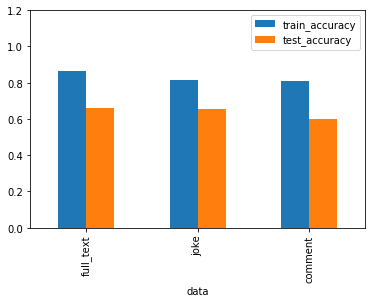

In [150]:
#Plot average train and test accuracy scores based on Joke, Comment, Full Text
model_df.groupby('data')[['train_accuracy','test_accuracy']].mean().sort_values(by='test_accuracy', ascending=False).plot(kind='bar', ylim=(0,1.2));

In [308]:
#Check our average train and test accuracy scores based on Joke, Comment, Full Text
model_df.groupby('data')[['train_accuracy','test_accuracy', 'abs_diff']].mean().round(3)

,train_accuracy,test_accuracy,abs_diff
data,,,
comment,0.811,0.602,0.209
full_text,0.864,0.658,0.206
joke,0.813,0.655,0.158


#### *Question: Which Vectorizer did best?*


While TfidfVectorizer demonstrate stronger accuracy against our training data set, we see that **CountVectorizer** outperformed against our test data. We also see that he gap between our training and test sets is lower in the case of CountVectorizer.

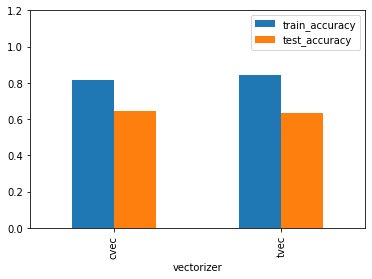

In [176]:
#Plot average train and test accuracy scores based on Cvec v Tvec
model_df.groupby('vectorizer')[['train_accuracy','test_accuracy']].mean().sort_values(by='test_accuracy', ascending=False).plot(kind='bar', ylim=(0,1.2));

In [310]:
#Check our average train and test accuracy scores based on CountVec v TfidfVec
model_df.groupby('vectorizer')[['train_accuracy','test_accuracy', 'abs_diff']].mean().round(3)

,train_accuracy,test_accuracy,abs_diff
vectorizer,,,
cvec,0.818,0.644,0.174
tvec,0.841,0.633,0.207


#### *Question: Which model produced the strongest accuracy score?*


**SVC, RandomForest, LogisticRegression, and MultinomialNB models** were among the most accurate models against the test set. However, there is a staggering gap in accuracy between accuracy against the training set and test sets for SVC and RandomForest, suggesting high variance. 

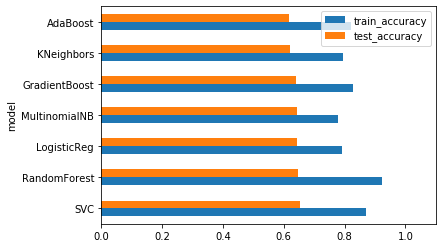

In [324]:
#Check our average train and test accuracy scores based on Model
model_df.groupby('model')[['train_accuracy','test_accuracy']].mean().sort_values(by='test_accuracy', ascending=False).plot(kind='barh', xlim=(0,1.1));

In [311]:
model_df.groupby('model')[['train_accuracy','test_accuracy', 'abs_diff']].mean().sort_values(by='test_accuracy', ascending=False).round(3)

,train_accuracy,test_accuracy,abs_diff
model,,,
SVC,0.869,0.654,0.215
RandomForest,0.922,0.648,0.274
LogisticReg,0.791,0.645,0.146
MultinomialNB,0.779,0.643,0.136
GradientBoost,0.827,0.642,0.185
KNeighbors,0.796,0.621,0.175
AdaBoost,0.821,0.618,0.203


In [327]:
model_df[['data','processing','vectorizer','model','train_accuracy','test_accuracy', 'abs_diff']].sort_values(by='test_accuracy', ascending=False).round(3).head(8)

,data,processing,vectorizer,model,train_accuracy,test_accuracy,abs_diff
58,full_text,lemmatize,cvec,LogisticReg,0.823,0.696,0.126
72,joke,none,cvec,SVC,0.812,0.689,0.123
46,full_text,lemmatize,cvec,RandomForest,1.000,0.684,0.316
83,full_text,lemmatize,tvec,SVC,0.954,0.681,0.273
82,full_text,lemmatize,cvec,SVC,0.902,0.680,0.222
40,full_text,none,cvec,RandomForest,1.000,0.680,0.320
76,full_text,none,cvec,SVC,0.783,0.678,0.105
78,joke,lemmatize,cvec,SVC,0.840,0.678,0.162


### Ensembling 

We're still seeing quite a bit gap between our training accuracy and test accuracy. Let's see if we can ensemble to reduce this...

In [98]:
cvec_fulltext_lem_ensemble = CountVectorizer()
cvec_fulltext_lem_ensemble.fit(X_train_fulltext_lem)

X_train_fulltext_lem_ensemble_cvec = cvec.transform(X_train_fulltext_lem)
X_test_fulltext_lem_ensemble_cvec = cvec.transform(X_test_fulltext_lem)

In [109]:
vote = VotingClassifier([
    ('log', LogisticRegression(random_state=42)),
    ('SVC',  SVC()),
    ('mnb',  MultinomialNB()),
    ('gb', GradientBoostingClassifier(random_state=42))
])
vote_params = {
    'gb__n_estimators': [100,150,175],
    'gb__max_depth': [1,2,3,4],
    'log__penalty':['l2','l1'],
    'log__C':[.01,0.1, 1],  
}
vote_model = GridSearchCV(vote, param_grid=vote_params, cv=3)
vote_model.fit(X_train_fulltext_lem_ensemble_cvec, y_train)

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=VotingClassifier(estimators=[('log',
                                                     LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='warn',
                                                                        n_jobs=None,
                                                                        penalty='l2',
             

In [110]:
print(vote_model.best_score_)
vote_model.score(X_test_fulltext_lem_ensemble_cvec, y_test)

0.682699767261443


0.7039370078740157

***
## <span style="color:blue">**Alternative Non-NLP Model**</span>

### Setup

So far, we have leveraged advanced modeling methods to classify whether or not our text is coming from r/Jokes, or r/DadJokes. Now, we will take a step back and take a simpler approach to see if a significantly culled down list of features, and our knowledge of dad joke constructs, can be an effective classification algorithm. To explore this, we'll return to our original data, and pull in the following features:
 - Profanity Flag
 - Pun Flag
 - Joke_Length
 - Num_Comments
 - Setup Dummies ("What do...", "Why do...")

Our hypothesis here is that Dad jokes are clean, often involve puns (recall that we have a list of homophones/homonyms), are shorter in general than normal jokes, and generate less comments than a regular joke. Let's see what we find!

In [104]:
#Isolate for the features we're interested in
X_additional = jokes_df[['profanity','pun','joke_length', 'num_comments','setup_did you',
       'setup_how do', 'setup_what do', 'setup_why do']]

In [298]:
#Bring back our baseline for reference
y.value_counts(normalize=True).round(2)

1    0.58
0    0.42
Name: subreddit, dtype: float64

In [105]:
#Create a new train test split for our new feature set
X_train_add, X_test_add, y_train, y_test = train_test_split(X_additional,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [116]:
from sklearn.model_selection import cross_val_score

#Score out model against training data and test data
vote_model.fit(X_train_add,y_train)


C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warn

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warn

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=VotingClassifier(estimators=[('log',
                                                     LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='warn',
                                                                        n_jobs=None,
                                                                        penalty='l2',
             

In [117]:
print(vote_model.best_score_)
print(vote_model.score(X_test_add, y_test))

0.6679596586501164
0.6929133858267716


There are a couple of interesting things here. First, note that our test scores are above average when compared to the set of models explore through our earlier analysis of more advanced methods. Second, note that the training score and test score are **significantly closer** than more advanced models. This is particularly true in the case of RandomForest, for example, which exhibited signs of significant overfitting. This shows that a simple approach can not only be as effective, but also display less variance.

***
# <span style="color:blue">**Differentiating Features**</span>

Now that we have a model selected, it's time to understand what is really driving differentiation between a dad joke, and a normal joke. In order to do this, we'll take our winning model and assess some of it's properties. In this section, we're interested in digging into the following questions:

 - *What words are most closely associated with a normal joke? A Dad joke?*
 - *What do the jokes look like when our model is confident and wrong?*
 - *What does our confusion matrix, and ROC curve tell us about our model?*
 
We'll start by re-generating our winning Logistic Regression model here. For ease of interpretation in this section we'll lean on non-lemmetized data.

In [1491]:
#Walk through Pipe, Param Grid, GridSearch process
pipe_lr_cvec_fulltext = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr' , LogisticRegression())
])

pipe_params_lr_cvec_fulltext = {
    'cvec__max_features': [1200,1500],
    'cvec__max_df': [.3,.4,.5,.65,.75,.85],
    'cvec__ngram_range': [(1,1)],
    'lr__penalty':['l2','l1'],
    'lr__C':[.01,0.1, 1]
}

gs_lr_cvec_fulltext = GridSearchCV(pipe_lr_cvec_fulltext, 
                  pipe_params_lr_cvec_fulltext, 
                  cv=3)


In [1493]:
#Fit model and store best model
gs_lr_cvec_fulltext.fit(X_train_fulltext,y_train)
lr_best_model = gs_lr_cvec_fulltext.best_estimator_

C:\Users\Owen\Anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Question: What words are most closely associated with r/DadJokes vs r/NormalJokes?**

We can use the coefficients from our model to answer this question. Our coefficients will relate back to our binary target in the following way: **particularly negative coefficients will be more predictive of our negative outcome (r/Jokes); particularly positive coefficients will be more predictive of our positive outcome (r/DadJokes)**. As we dig in, we realize that more negative coeffcients are generally associated with offensive topics (religion, race); more positive coefficients are more closely associated with familial/simple contextual terms (daughter/father; walking/eating). We can plot these to better chart these relationships.

In [512]:
#Grab resulting coefficients and toss into a data frame
coef_df = pd.DataFrame(lr_best_model.steps[1][1].coef_).T

In [513]:
coef_df.columns = ['coefficient']
coef_df['word'] = lr_best_model.steps[0][1].get_feature_names()
coef_df = coef_df.sort_values('coefficient')

In [514]:
coef_df.head(8)

,coefficient,word
532,-0.439292,girl
684,-0.423602,jesus
1448,-0.412235,whats
648,-0.405302,husband
568,-0.384384,guy
1465,-0.382760,woman
800,-0.376269,man
359,-0.374950,difference


In [515]:
coef_df.tail(8)

,coefficient,word
1415,0.263037,walking
1445,0.263095,went
747,0.268991,legs
357,0.273967,died
1097,0.274189,runclejokes
314,0.299580,dad
781,0.350365,looking
277,0.357550,cool


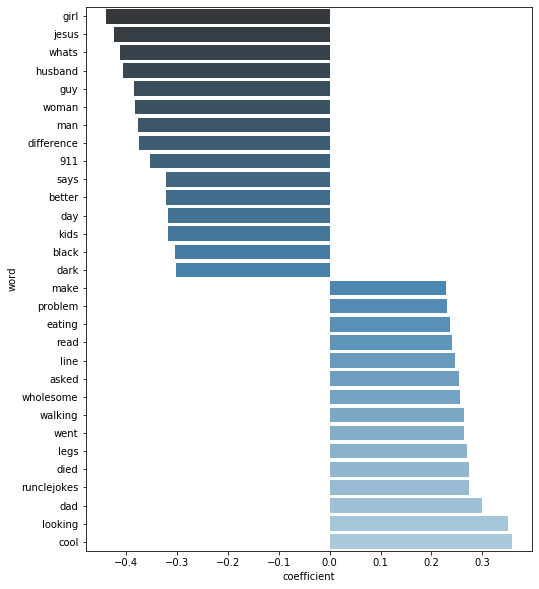

In [498]:
plt.figure(figsize=(8,10))
sns.barplot(data=joke_words, x='coefficient', y='word',orient='h',
palette=("Blues_d"));


**Question: What do the jokes look like when our model is confident and wrong?**

What does our model get REALLY wrong? Let's try to isolate for **False Positives** and **False Negatives** when our model is confident in it's classifications. This will allow us to identify any trends that we can potentially feed back into our model. We'll accomplish this by leveraging **.predict_proba()** to access observation level probabilities. We'll then connect those probabilities back to the original text through **joke_id.**

When we do this, we notice a couple of interesting things:
 - First, it looks like some r/Jokes posts closely resemble r/DadJokes post. This isn't surprising-- it's very likely that users that frequent one of these subreddits also frequent the other.
 - Comments can be vulgar, offtopic, and random on both of these subreddits. This may be one reason why a model train solely on comment data is not as effective

In [516]:
#Build a dataframe of our predict probas, and the actual classifications
X_train_fulltext_df = pd.DataFrame(X_train_fulltext)
X_train_fulltext_df['y_train'] = y_train
X_train_fulltext_probas = pd.DataFrame(lr_best_model.predict_proba(X_train_fulltext))

In [518]:
#jokeID will connect our model probabilities to our words
X_train_fulltext_probas['joke_id'] = pd.Series(X_train_fulltext.index)
X_train_fulltext_df['joke_id'] = pd.Series(X_train_fulltext.index)

In [519]:
#Merge our dataframes
X_train_fulltext_df = pd.merge(X_train_fulltext_df, X_train_fulltext_probas, left_on='joke_id',right_on='joke_id')

In [522]:
#Jokes that our algorithm confidently thought were dad jokes
list(X_train_fulltext_df.loc[(X_train_fulltext_df['y_train'] == 0) &(X_train_fulltext_df[1] > .88),'full_text'])

['my wife got onto me the other day claiming i spent too much time moistening food while cooking thinking the accusations as ridiculous i asked baste on what So You got kids yet Youre ready I bet you glazed over while she grilled you Nice to meat you have an upvote',
 'a husband was bit embarrassed and told the doctor he had trouble getting an erection a husband was a bit embarrassed and told the doctor he had trouble getting an erection with his wife and she was getting frustrated the doc checked the mans blood pressure and other vitals then after a thorough examination said he wanted to check with the wife he took her to another cubicle and asked her to disrobe then he told her to turn all the way around slowly she did as instructed he then told her to raise her arms above her head then bend over touch her toes and cough finally he said ok good you can get dressed now and i will go talk to your husband the doctor went back to the other cubicle and said to the husband well bill you ca

In [525]:
#Dad Jokes that our algorithm confidently thought were jokes
list(X_train_fulltext_df.loc[(X_train_fulltext_df['y_train'] == 1) &(X_train_fulltext_df[0] > .99),'full_text'])

['who says oh oh oh santa walking backwards  ',
 'i asked my son hey what do you call a rubber loop that you put rocks and bread into he shrugged and said he had no idea so i answered a rock and roll band  ',
 'my mattress is starting to hurt my back but i dont know if i can afford a new one i think ill just sleep on it  ',
 'son dad can you tell me what a solar eclipse is dad no sun How punny Wasnt this like the top last week Can we try and space out the reposts Its Mitsubishis attempt to compete with Tesla Well played dad Gibbous more of these space puns did he tell him SUN OF A BITCH Damn Thats dark Fine then keep your secrets My dad is an eclipse chaser and Im 100 sure hed do this if he had a son who asked him what a solar eclipse is',
 'the invention of the wheel is very wellrounded well spoken but now I am too tired Must be a bicycle The invention of the shovel was ground breaking revolutionary']

***What does our confusion matrix, and ROC curve tell us about our model?***

In [537]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Generate our predictions with this model.
preds = lr_best_model.predict(X_test_fulltext)

#Print our accuracy score, and classification report
print(f'Accuracy: {accuracy_score(y_test, preds)}')

#Store confusion_matrix returns for reference
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


spec = tn / (tn + fp)
print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens,4)}')

Accuracy: 0.6834645669291338
Specificity: 0.3843
Sensitivity: 0.9019


**Sensitivity is very good** for our model. This means that when the model predicts that a post is from r/DadJokes, it's often the case that this is true. On the other hand, **specificity is very, very bad here**. This means that it is not very good at all at effectively telling us when a joke actually belongs to **r/Jokes**. Given what we see above, it does appear that there are a good amount of r/Jokes observations that could, from a human vantage point, be interpreted as r/DadJokes.

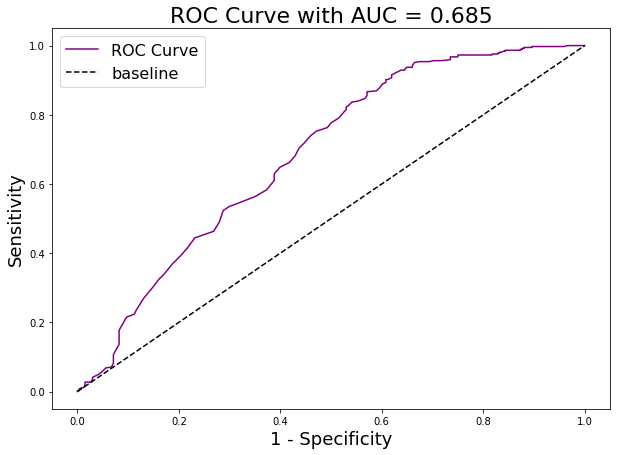

In [541]:
from sklearn.metrics import roc_auc_score
pred_proba = [i[1] for i in lr_best_model.predict_proba(X_test_fulltext)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve', c='purple')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--', c='black')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## <span style="color:Black">**Additional Analysis: Frequency**</span>

In [23]:
vec = CountVectorizer(stop_words='english').fit(X_train_joke)
bag_of_words = vec.transform(X_train_joke)
sum_words = bag_of_words.sum(axis=0)

In [24]:
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [25]:
words_freq[:]

[('man', 190),
 ('said', 181),
 ('says', 169),
 ('im', 148),
 ('ampx200b', 138),
 ('did', 134),
 ('just', 123),
 ('like', 105),
 ('dont', 104),
 ('dad', 102),
 ('asked', 98),
 ('wife', 97),
 ('know', 97),
 ('got', 85),
 ('say', 79),
 ('day', 77),
 ('people', 75),
 ('guy', 75),
 ('asks', 73),
 ('woman', 72),
 ('time', 66),
 ('whats', 63),
 ('told', 62),
 ('does', 60),
 ('going', 59),
 ('make', 57),
 ('goes', 56),
 ('went', 56),
 ('good', 56),
 ('bar', 55),
 ('old', 54),
 ('son', 51),
 ('joke', 49),
 ('tell', 48),
 ('home', 46),
 ('walks', 46),
 ('life', 46),
 ('night', 46),
 ('really', 45),
 ('thats', 45),
 ('little', 45),
 ('ill', 45),
 ('didnt', 42),
 ('bartender', 42),
 ('today', 42),
 ('replied', 42),
 ('replies', 41),
 ('door', 41),
 ('god', 41),
 ('friend', 40),
 ('years', 40),
 ('ive', 39),
 ('doctor', 39),
 ('want', 39),
 ('looks', 38),
 ('way', 35),
 ('getting', 35),
 ('new', 35),
 ('come', 35),
 ('think', 34),
 ('fish', 34),
 ('hear', 33),
 ('came', 33),
 ('girl', 32),
 ('husb

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [32]:
lvec.vocabulary_.keys()

dict_keys(['wanna', 'hear', 'joke', 'communism', 'oh', 'sorry', 'understand', 'funny', 'unless', 'gets', 'wife', 'says', 'wants', 'spend', 'halloween', 'decorations', 'year', 'said', 'lets', 'store', 'jumps', 'yes', 'really', 'happened', 'think', 'biggest', 'eye', 'roll', 'ive', 'gotten', 'got', 'married', 'dated', 'daughters', 'chobani', 'family', 'college', 'broke', 'uncultured', 'doctor', 'youre', 'saying', 'masturbate', 'want', 'david', 'aid', 'stroke', 'time', 'whats', 'inches', 'long', 'wide', 'drives', 'women', 'crazy', 'toilet', 'paper', 'herding', 'dog', 'theatre', 'tonight', 'children', 'performing', 'let', 'coliseum', 'things', 'dad', 'crawdads', 'doodads', 'hodads', 'mom', 'babysitter', 'secondgrade', 'primary', 'school', 'teacher', 'invited', 'girlfriend', 'gym', 'didnt', 'hope', 'message', 'working', 'bought', 'coconut', 'shampoo', 'day', 'home', 'realised', 'police', 'officers', 'crash', 'car', 'tree', 'moment', 'silence', 'wow', 'thats', 'fastest', 'accident', 'site', '

In [34]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(list(vec.vocabulary_.keys())
# plt.figure(figsize=(12,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

SyntaxError: unexpected EOF while parsing (<ipython-input-34-10466ded9c2d>, line 6)